In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_dir = Path("dataset/train")
val_dir   = Path("dataset/val")
test_dir  = Path("dataset/test")


In [14]:
def load_binary_dataset(directory):
    ds = image_dataset_from_directory(
        directory,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        label_mode="int"
    )

    class_names = ds.class_names
    class_names_tf = tf.constant(class_names)

    def to_binary(x, y):
        names = tf.gather(class_names_tf, y)
        names_lower = tf.strings.lower(names)
        is_healthy = tf.strings.regex_full_match(names_lower, ".*healthy.*")
        y_bin = tf.where(is_healthy, 0, 1)
        return x, tf.cast(y_bin, tf.int32)

    return ds.map(to_binary), class_names

train_ds, train_classes = load_binary_dataset(train_dir)
val_ds, _   = load_binary_dataset(val_dir)
test_ds, _  = load_binary_dataset(test_dir)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

# kurzer Check
for _, yb in train_ds.take(1):
    print("labels in train batch:", np.unique(yb.numpy()))


Found 14440 files belonging to 16 classes.
Found 3089 files belonging to 16 classes.
Found 3109 files belonging to 16 classes.
labels in train batch: [1]


2025-10-31 23:02:06.048654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype string and shape [16]
	 [[{{node Placeholder/_12}}]]
2025-10-31 23:02:06.048909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [14440]
	 [[{{node Placeholder/_0}}]]


In [15]:
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)
base_model.trainable = False

feature_extractor = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D()
])


In [16]:
def extract_features(dataset):
    feats_list = []
    labels_list = []
    for batch_imgs, batch_labels in dataset:
        batch_imgs = preprocess_input(batch_imgs)
        batch_feats = feature_extractor(batch_imgs)
        feats_list.append(batch_feats.numpy())
        labels_list.append(batch_labels.numpy())
    X = np.vstack(feats_list)
    y = np.hstack(labels_list)
    return X, y

print("🔄 extrahiere Features (train) ...")
X_train, y_train = extract_features(train_ds)

print("🔄 extrahiere Features (val) ...")
X_val, y_val = extract_features(val_ds)

print("🔄 extrahiere Features (test) ...")
X_test, y_test = extract_features(test_ds)

print("Shapes:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)


🔄 extrahiere Features (train) ...


2025-10-31 23:02:06.455630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype string and shape [16]
	 [[{{node Placeholder/_12}}]]
2025-10-31 23:02:06.455874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype string and shape [16]
	 [[{{node Placeholder/_12}}]]


🔄 extrahiere Features (val) ...


2025-10-31 23:06:17.405118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3089]
	 [[{{node Placeholder/_0}}]]
2025-10-31 23:06:17.405532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype string and shape [16]
	 [[{{node Placeholder/_12}}]]


🔄 extrahiere Features (test) ...


2025-10-31 23:08:19.786492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3109]
	 [[{{node Placeholder/_0}}]]
2025-10-31 23:08:19.787015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype string and shape [16]
	 [[{{node Placeholder/_12}}]]


Shapes: (14440, 512) (14440,) (3109, 512) (3109,)


In [17]:
svm = SVC(
    kernel="rbf",
    C=2.0,
    gamma="scale",
    class_weight="balanced"
)
svm.fit(X_train, y_train)


SVC(C=2.0, class_weight='balanced')


📊 Classification Report:
              precision    recall  f1-score   support

     Healthy       0.93      0.99      0.96       487
    Diseased       1.00      0.99      0.99      2622

    accuracy                           0.99      3109
   macro avg       0.97      0.99      0.98      3109
weighted avg       0.99      0.99      0.99      3109



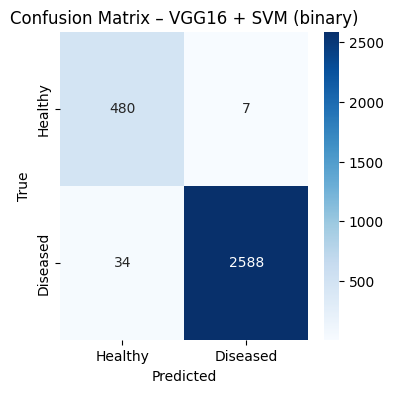

In [18]:
y_pred = svm.predict(X_test)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Healthy", "Diseased"]))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Healthy", "Diseased"],
    yticklabels=["Healthy", "Diseased"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – VGG16 + SVM (binary)")
plt.show()


In [19]:
"""""
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# -------------------------------------------------
# 1) Pfade
# -------------------------------------------------
train_dir = Path("dataset/train")
val_dir   = Path("dataset/val")
test_dir  = Path("dataset/test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# -------------------------------------------------
# 2) Helper: Dataset laden und auf binary mappen
#    healthy -> 0, alles andere -> 1
# -------------------------------------------------
def load_binary_dataset(directory):
    ds = image_dataset_from_directory(
        directory,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,    # wichtig! Reihenfolge behalten
        label_mode="int"  # wir mappen gleich selbst auf 0/1
    )

    class_names = ds.class_names        # z.B. ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', ...]
    class_names_tf = tf.constant(class_names)

    def to_binary(x, y):
        # y: (batch,) -> indices in class_names
        names = tf.gather(class_names_tf, y)
        names_lower = tf.strings.lower(names)
        is_healthy = tf.strings.regex_full_match(names_lower, ".*healthy.*")
        y_bin = tf.where(is_healthy, 0, 1)   # healthy=0, sonst=1
        return x, tf.cast(y_bin, tf.int32)

    ds_bin = ds.map(to_binary)
    return ds_bin, class_names

train_ds, train_classes = load_binary_dataset(train_dir)
val_ds, _   = load_binary_dataset(val_dir)
test_ds, _  = load_binary_dataset(test_dir)

# Prefetch für Speed
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

# Sanity check: zeigen, was wirklich drin ist
y_check = []
for _, yb in train_ds.take(5):
    y_check.extend(yb.numpy().tolist())
print("🔎 Beispiel-Labels aus train:", set(y_check))
# hier solltest du {0, 1} sehen

# -------------------------------------------------
# 3) VGG16-Feature-Extractor
# -------------------------------------------------
base_model = VGG16(weights="imagenet",
                   include_top=False,
                   input_shape=IMG_SIZE + (3,))
base_model.trainable = False

feature_extractor = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D()
])

# -------------------------------------------------
# 4) Features extrahieren
# -------------------------------------------------
def extract_features(dataset):
    feats_list = []
    labels_list = []
    for batch_imgs, batch_labels in dataset:
        # VGG16 erwartet preprocess_input
        batch_imgs = preprocess_input(batch_imgs)
        batch_feats = feature_extractor(batch_imgs)
        feats_list.append(batch_feats.numpy())
        labels_list.append(batch_labels.numpy())
    X = np.vstack(feats_list)
    y = np.hstack(labels_list)
    return X, y

print("🔄 extrahiere Features (train) ...")
X_train, y_train = extract_features(train_ds)
print("🔄 extrahiere Features (val) ...")
X_val, y_val = extract_features(val_ds)
print("🔄 extrahiere Features (test) ...")
X_test, y_test = extract_features(test_ds)

print("Shapes:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print("Train-Klassen:", np.unique(y_train, return_counts=True))

# -------------------------------------------------
# 5) SVM trainieren
# -------------------------------------------------
from sklearn.svm import SVC

# class_weight='balanced' ist bei dir wichtig
svm = SVC(kernel="rbf", C=2.0, gamma="scale", class_weight="balanced")
svm.fit(X_train, y_train)

# -------------------------------------------------
# 6) Auswertung
# -------------------------------------------------
y_pred = svm.predict(X_test)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Healthy", "Diseased"]))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Healthy", "Diseased"],
            yticklabels=["Healthy", "Diseased"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – VGG16 + SVM (binary)")
plt.show()

"""""

'""\nimport numpy as np\nimport tensorflow as tf\nfrom tensorflow.keras.applications import VGG16\nfrom tensorflow.keras.applications.vgg16 import preprocess_input\nfrom tensorflow.keras.preprocessing import image_dataset_from_directory\nfrom sklearn.svm import SVC\nfrom sklearn.metrics import classification_report, confusion_matrix\nimport seaborn as sns\nimport matplotlib.pyplot as plt\nfrom pathlib import Path\n\n# -------------------------------------------------\n# 1) Pfade\n# -------------------------------------------------\ntrain_dir = Path("dataset/train")\nval_dir   = Path("dataset/val")\ntest_dir  = Path("dataset/test")\n\nIMG_SIZE = (224, 224)\nBATCH_SIZE = 32\n\n# -------------------------------------------------\n# 2) Helper: Dataset laden und auf binary mappen\n#    healthy -> 0, alles andere -> 1\n# -------------------------------------------------\ndef load_binary_dataset(directory):\n    ds = image_dataset_from_directory(\n        directory,\n        image_size=IMG_SI

/opt/anaconda3/envs/tfarm/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


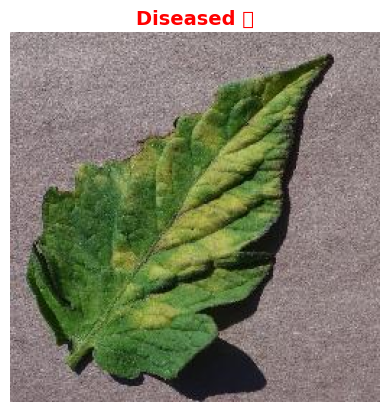

Bild: /Users/umerhanif/Desktop/UNI/SEM5/KI & ML Projekt/KI-Machine-Learning/dataset/val/Tomato_Leaf_Mold/9afdf72c-5e19-40bd-8035-daf70f1cf8ce___Crnl_L.Mold 6617.JPG
Vorhersage: Diseased 🌿


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

IMG_SIZE = (224, 224)

# 1) Pfad zu einem Testbild
img_path = "/Users/umerhanif/Desktop/UNI/SEM5/KI & ML Projekt/KI-Machine-Learning/dataset/val/Tomato_Leaf_Mold/9afdf72c-5e19-40bd-8035-daf70f1cf8ce___Crnl_L.Mold 6617.JPG"
# nimm hier einfach ein anderes aus deinem dataset/test/...

# 2) Bild laden
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# 3) Features mit VGG16 holen
features = feature_extractor.predict(img_array, verbose=0)  # verbose=0 -> kein 1/1-Output

# 4) Mit SVM klassifizieren
pred = svm.predict(features)[0]        # 0 = healthy, 1 = diseased
label = "Diseased 🌿" if pred == 1 else "Healthy 🍃"
color = "red" if pred == 1 else "green"

# 5) anzeigen
plt.imshow(plt.imread(img_path))
plt.axis("off")
plt.title(f"{label}", color=color, fontsize=14, weight="bold")
plt.show()

print("Bild:", img_path)
print("Vorhersage:", label)


/var/folders/t8/prdvm2s15t59h3tqywj46zqw0000gn/T/ipykernel_4306/1109142806.py:60: UserWarning: Glyph 127811 (\N{LEAF FLUTTERING IN WIND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/t8/prdvm2s15t59h3tqywj46zqw0000gn/T/ipykernel_4306/1109142806.py:60: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/tfarm/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127811 (\N{LEAF FLUTTERING IN WIND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/tfarm/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


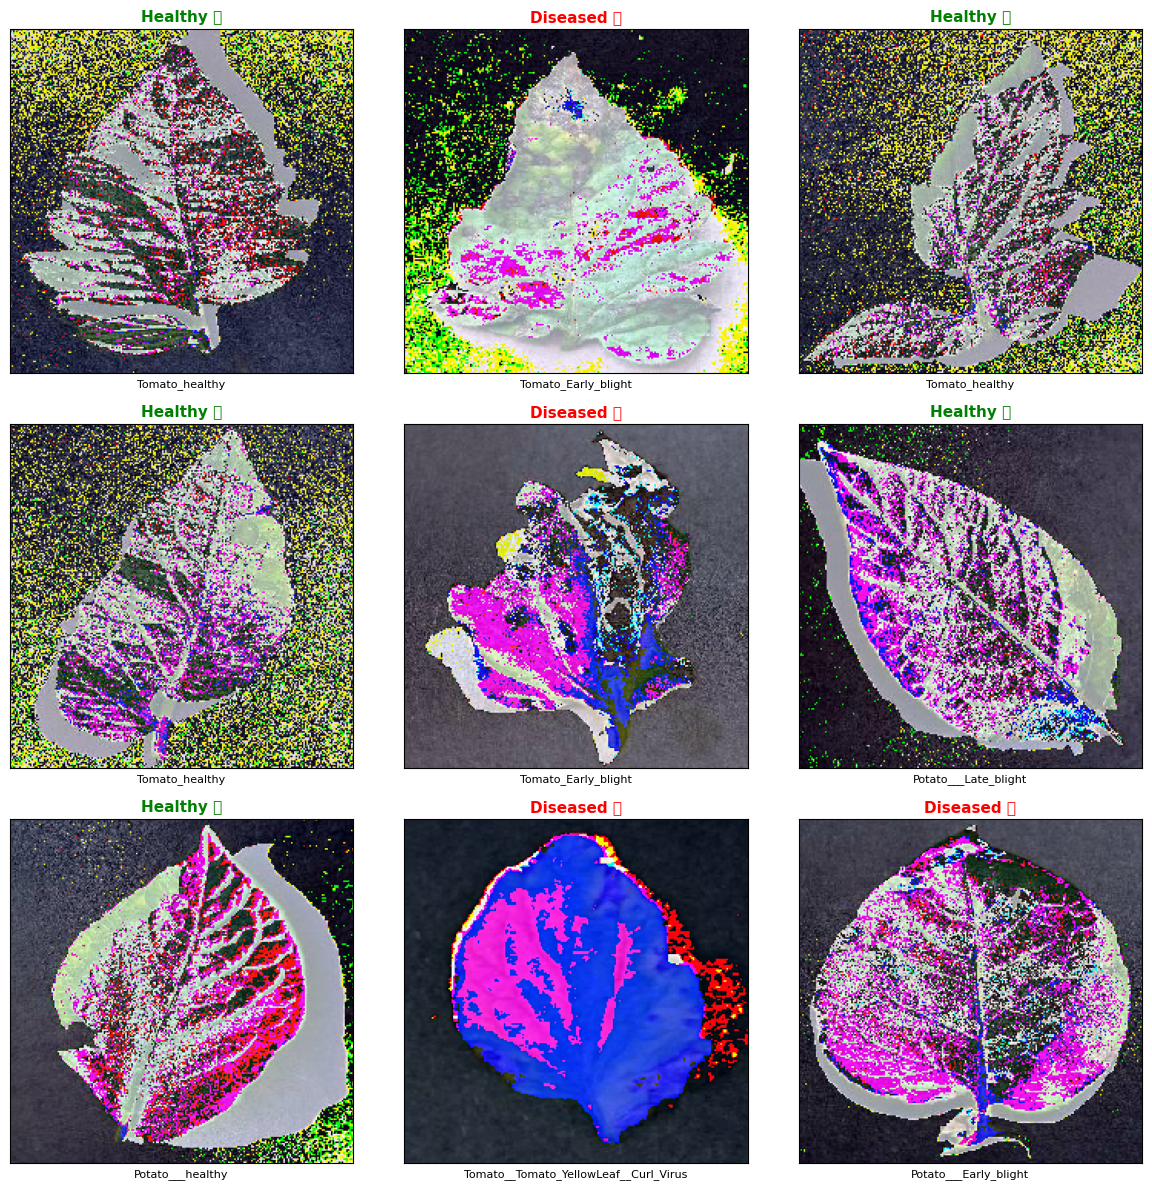

In [21]:
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

IMG_SIZE = (224, 224)

def show_batch_predictions(
    root_dir="dataset/test",
    n_images=9,
    rows=3,
    cols=3,
):
    root = Path(root_dir)

    # alle Bilddateien aus test/ einsammeln (egal welche Klasse)
    all_images = (
        list(root.rglob("*.jpg"))
        + list(root.rglob("*.JPG"))
        + list(root.rglob("*.jpeg"))
        + list(root.rglob("*.png"))
    )

    if len(all_images) == 0:
        print("⚠️ Keine Bilder gefunden in", root_dir)
        return

    # zufällig n_images auswählen
    selected = random.sample(all_images, min(n_images, len(all_images)))

    plt.figure(figsize=(12, 12))

    for i, img_path in enumerate(selected):
        # Bild laden
        img = image.load_img(img_path, target_size=IMG_SIZE)
        img_array = image.img_to_array(img)
        x = np.expand_dims(img_array, axis=0)
        x = preprocess_input(x)

        # Features -> SVM
        feats = feature_extractor.predict(x, verbose=0)
        pred = svm.predict(feats)[0]      # 0 = healthy, 1 = diseased

        label = "Diseased 🌿" if pred == 1 else "Healthy 🍃"
        color = "red" if pred == 1 else "green"

        # anzeigen
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img_array.astype("uint8"))
        ax.set_title(label, color=color, fontsize=11, weight="bold")
        ax.set_xticks([])
        ax.set_yticks([])

        # kleinen Pfad anzeigen (nur Klassenordner)
        cls_name = img_path.parent.name
        ax.set_xlabel(cls_name, fontsize=8)

    plt.tight_layout()
    plt.show()

# aufrufen
show_batch_predictions(
    root_dir="dataset/test",
    n_images=9,
    rows=3,
    cols=3,
)


❌ 112 falsche Vorhersagen gefunden aus 3109 Bildern.


/var/folders/t8/prdvm2s15t59h3tqywj46zqw0000gn/T/ipykernel_4306/2640139435.py:63: UserWarning: Glyph 127811 (\N{LEAF FLUTTERING IN WIND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/t8/prdvm2s15t59h3tqywj46zqw0000gn/T/ipykernel_4306/2640139435.py:63: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/tfarm/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127811 (\N{LEAF FLUTTERING IN WIND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/tfarm/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


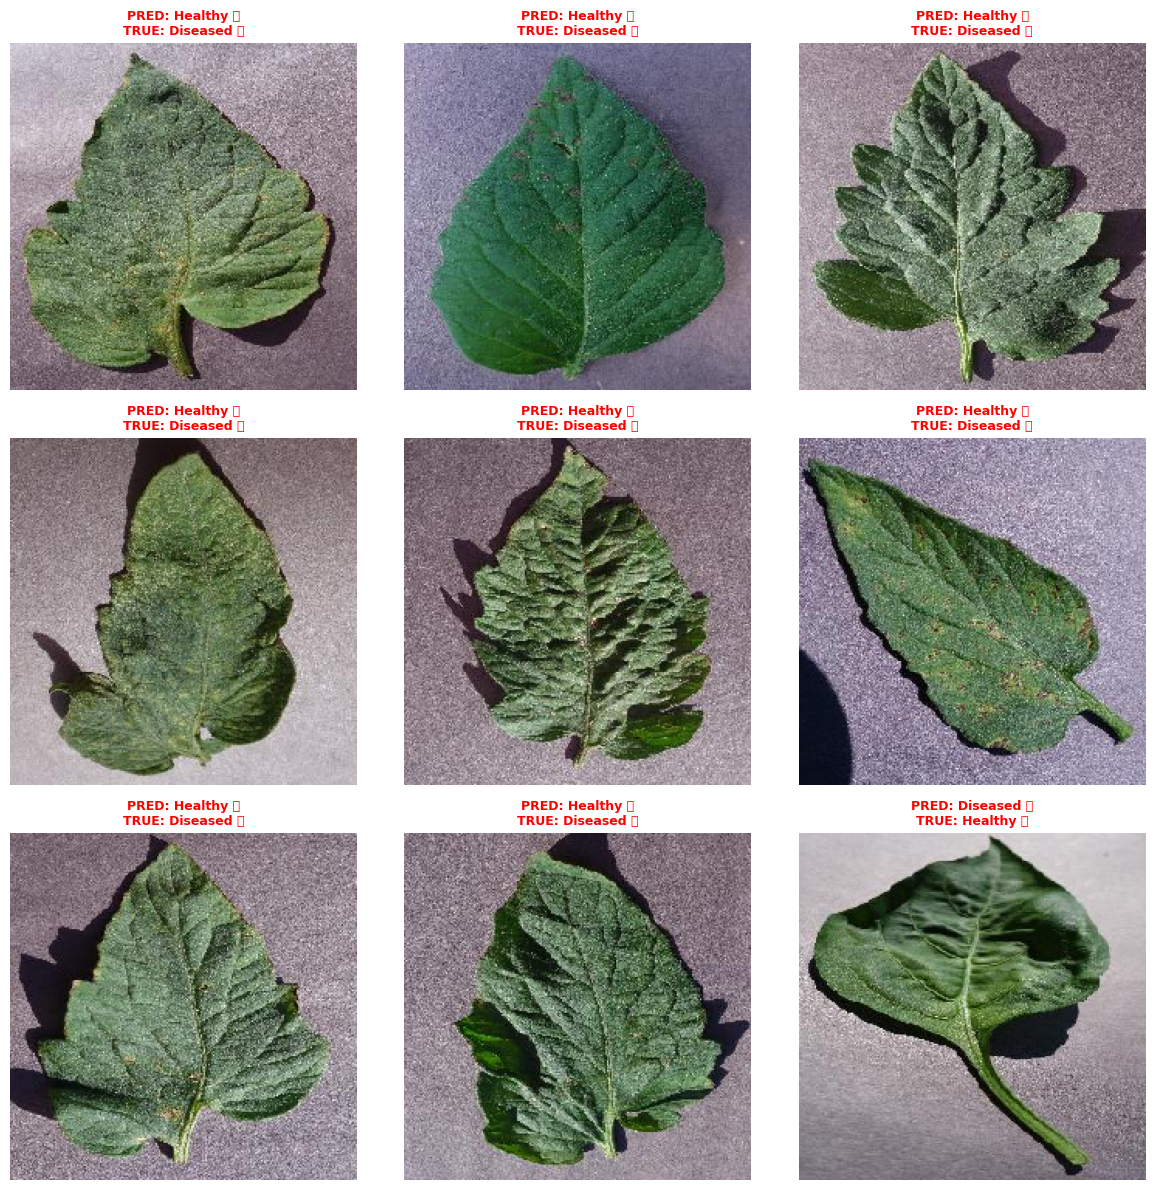

In [22]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
from pathlib import Path
import random

IMG_SIZE = (224, 224)

def show_false_predictions(root_dir="dataset/test", max_images=9, rows=3, cols=3):
    root = Path(root_dir)

    # Alle Testbilder einsammeln
    all_images = (
        list(root.rglob("*.jpg"))
        + list(root.rglob("*.JPG"))
        + list(root.rglob("*.jpeg"))
        + list(root.rglob("*.png"))
    )

    false_preds = []

    for img_path in all_images:
        # Wahres Label aus Ordnername ableiten
        true_label = 0 if "healthy" in img_path.name.lower() or "healthy" in img_path.parent.name.lower() else 1

        # Bild vorbereiten
        img = image.load_img(img_path, target_size=IMG_SIZE)
        img_array = image.img_to_array(img)
        x = np.expand_dims(img_array, axis=0)
        x = preprocess_input(x)

        # Vorhersage mit VGG16 + SVM
        feats = feature_extractor.predict(x, verbose=0)
        pred = svm.predict(feats)[0]

        if pred != true_label:
            false_preds.append((img_path, true_label, pred))

    print(f"❌ {len(false_preds)} falsche Vorhersagen gefunden aus {len(all_images)} Bildern.")

    if not false_preds:
        print("Alles korrekt erkannt 🎉")
        return

    # Zufällig einige Fehlklassifikationen anzeigen
    sample = random.sample(false_preds, min(max_images, len(false_preds)))

    plt.figure(figsize=(12, 12))
    for i, (path, true_label, pred_label) in enumerate(sample):
        ax = plt.subplot(rows, cols, i + 1)
        img = image.load_img(path, target_size=IMG_SIZE)
        plt.imshow(img)
        ax.axis("off")

        true_txt = "Healthy 🍃" if true_label == 0 else "Diseased 🌿"
        pred_txt = "Healthy 🍃" if pred_label == 0 else "Diseased 🌿"

        ax.set_title(f"PRED: {pred_txt}\nTRUE: {true_txt}",
                     color=("red" if pred_label != true_label else "black"),
                     fontsize=9, weight="bold")
        ax.set_xlabel(path.parent.name, fontsize=8)
    plt.tight_layout()
    plt.show()

# Aufruf:
show_false_predictions("dataset/test", max_images=9)
